In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *

3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]


In [2]:
#import training dataset

dataset = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/grand_salon_12_12_b/torch_dataset_all.pkl')

print(dataset)
print(len(dataset))

cmd_left_str_list = []
cmd_right_str_list = []
for i in range(0, 40):
    str_cmd_left_i = 'cmd_left_' + str(i)
    str_cmd_right_i = 'cmd_right_' + str(i)
    cmd_left_str_list.append(str_cmd_left_i)
    cmd_right_str_list.append(str_cmd_right_i)
cmd_left_vels_array = dataset[cmd_left_str_list].to_numpy()
cmd_right_vels_array = dataset[cmd_right_str_list].to_numpy()

encoder_left_str_list = []
encoder_right_str_list = []
for i in range(0, 40):
    str_encoder_left_i = 'left_wheel_vel_' + str(i)
    str_encoder_right_i = 'right_wheel_vel_' + str(i)
    encoder_left_str_list.append(str_encoder_left_i)
    encoder_right_str_list.append(str_encoder_right_i)
encoder_left_vels_array = dataset[encoder_left_str_list].to_numpy()
encoder_right_vels_array = dataset[encoder_right_str_list].to_numpy()

# import input space info
input_space_dataframe = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/input_space/input_space_data.pkl')
ideal_diff_drive = Ideal_diff_drive(input_space_dataframe['calibrated_radius [m]'].to_numpy()[0], input_space_dataframe['calibrated baseline [m]'].to_numpy()[0], 0.05)

# import model error
ideal_diff_drive_errors_dataframe = pd.read_pickle('../data/marmotte/eval_results/grand_salon_b/ideal_diff_drive_full_eval_metrics.pkl')
enhanced_kinematic_errors_dataframe = pd.read_pickle('../data/marmotte/eval_results/grand_salon_b/enhanced_kinematic_full_eval_metrics.pkl')
print(ideal_diff_drive_errors_dataframe)
print(len(ideal_diff_drive_errors_dataframe))

     init_icp_x  init_icp_y  init_icp_z  init_icp_roll  init_icp_pitch  \
0      0.000000    0.000000    0.000000       0.000000        0.000000   
1      0.008955   -0.000817    0.003175      -0.001797        0.006842   
2      0.007267   -0.000082    0.001521      -0.002199        0.006909   
3      0.006334   -0.001298    0.002206      -0.001787        0.007261   
4      0.005491   -0.000265    0.001215      -0.001595        0.006859   
..          ...         ...         ...            ...             ...   
734   -4.908478   -0.194696   -0.075796       0.007526        0.014339   
735   -6.110772   -0.703211   -0.051747      -0.018082        0.002857   
736   -6.120254   -0.691927   -0.046963      -0.005544        0.011006   
737   -6.119847   -0.692307   -0.048081      -0.005805        0.011418   
738   -6.121067   -0.691024   -0.047965      -0.005566        0.011321   

     init_icp_yaw  calib_step  cmd_left_0  cmd_right_0  cmd_left_1  ...  \
0        0.000000         0.0     0.

In [3]:
#init model and estimate displacement

body_inertia = 0.8336
body_mass = 70

input_space_dataframe = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/input_space/input_space_data.pkl')
r = input_space_dataframe['calibrated_radius [m]'].to_numpy()[0]
baseline = input_space_dataframe['calibrated baseline [m]'].to_numpy()[0]
dt = 0.05

trained_params_path = '../eval/training_results/marmotte/enhanced_kinematic/grand_salon_a/train_full_all_horizons.npy'
trained_params = np.load(trained_params_path)

init_stoch_params = np.zeros(6)


# import input space info
input_space_dataframe = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/input_space/input_space_data.pkl')
ideal_diff_drive = Ideal_diff_drive(input_space_dataframe['calibrated_radius [m]'].to_numpy()[0], input_space_dataframe['calibrated baseline [m]'].to_numpy()[0], 0.05)
icr_asymmetric_params = np.load('../eval/training_results/marmotte/icr_asymmetrical/grand_salon_a/train_full_all_horizons.npy')


enhanced_kinematic = Enhanced_kinematic(r, baseline, body_inertia, body_mass, trained_params, init_stoch_params, dt)


In [57]:
# predict vehicle displacement along window

window_id = 405
print(cmd_left_vels_array.shape[1])
window_size = cmd_left_vels_array.shape[1]

init_state = np.array([dataset['init_icp_x'][window_id], dataset['init_icp_y'][window_id], dataset['init_icp_x'][window_id]])

predicted_states_idd = np.zeros((window_size, 6))
predicted_states_idd[0, 0] = dataset['init_icp_x'][window_id]
predicted_states_idd[0, 1] = dataset['init_icp_y'][window_id]
predicted_states_idd[0, 2] = dataset['init_icp_z'][window_id]
predicted_states_idd[0, 3] = dataset['init_icp_roll'][window_id]
predicted_states_idd[0, 4] = dataset['init_icp_pitch'][window_id]
predicted_states_idd[0, 5] = dataset['init_icp_yaw'][window_id]

predicted_states_ek = np.zeros((window_size, 6))
predicted_states_ek[0, 0] = dataset['init_icp_x'][window_id]
predicted_states_ek[0, 1] = dataset['init_icp_y'][window_id]
predicted_states_ek[0, 2] = dataset['init_icp_z'][window_id]
predicted_states_ek[0, 3] = dataset['init_icp_roll'][window_id]
predicted_states_ek[0, 4] = dataset['init_icp_pitch'][window_id]
predicted_states_ek[0, 5] = dataset['init_icp_yaw'][window_id]

for i in range(1, window_size):
    input_array = np.array([cmd_left_vels_array[window_id, i-1], cmd_right_vels_array[window_id, i-1]])
    print(input_array)
    predicted_states_ek[i, :] = enhanced_kinematic.predict(predicted_states[i-1, :], input_array)
    predicted_states_idd[i, :] = ideal_diff_drive.predict(predicted_states[i-1, :], input_array)

print(dataset['init_icp_x'][window_id])
print(predicted_states[0, 0])

40
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700644 -1.62737983]
[10.34700

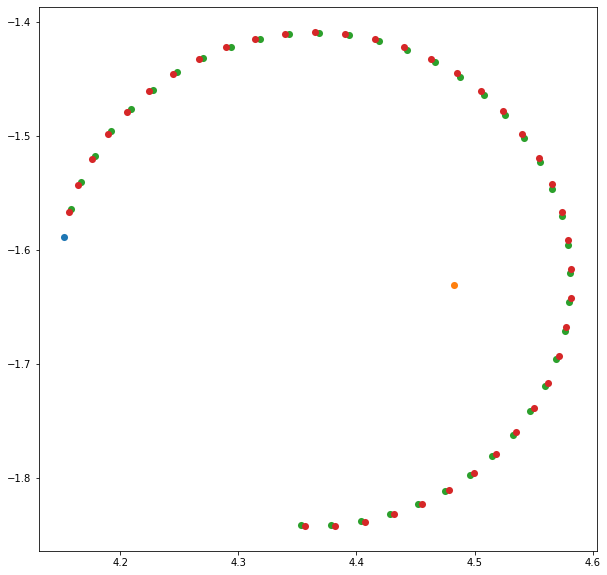

In [58]:
# plot uncertainty propagation

plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()

alpha_plot = 1.0

init_state = ax.scatter(dataset['init_icp_x'][window_id], dataset['init_icp_y'][window_id], 
                  c = 'C0', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='init_state',
                 rasterized=True)

end_state = ax.scatter(dataset['gt_icp_x'][window_id], dataset['gt_icp_y'][window_id], 
                  c = 'C1', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='end_state',
                 rasterized=True)

prediction_idd = ax.scatter(predicted_states_idd[1:, 0], predicted_states_idd[1:, 1], 
                  c = 'C2', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='end_state',
                 rasterized=True)

prediction_ek = ax.scatter(predicted_states_ek[1:, 0], predicted_states_ek[1:, 1], 
                  c = 'C3', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='end_state',
                 rasterized=True)